In [25]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import mean_absolute_error as MAE

sns.set(style="darkgrid")
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 100)
pd.set_option('max_colwidth', 800)
pd.options.display.float_format = '{:.4f}'.format

# Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.multioutput import MultiOutputRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# Models 
import torch
import xgboost as xgb
from xgboost import plot_importance, plot_tree

# Load Data

In [3]:
train_a = pd.read_parquet('data/A/train_targets.parquet')
train_b = pd.read_parquet('data/B/train_targets.parquet')
train_c = pd.read_parquet('data/C/train_targets.parquet')

In [4]:
train = pd.concat([train_a, train_b, train_c])

In [5]:
X_train_estimated_a = pd.read_parquet('data/A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('data/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('data/C/X_train_estimated.parquet')


In [6]:
X_train_observed_a = pd.read_parquet('data/A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('data/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('data/C/X_train_observed.parquet')


In [7]:
X_test_estimated_a = pd.read_parquet('data/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('data/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('data/C/X_test_estimated.parquet')

In [8]:
X_a = pd.concat([X_train_observed_a, X_train_estimated_a, X_test_estimated_a]).reset_index().drop(columns = "index")
X_b = pd.concat([X_train_observed_b, X_train_estimated_b, X_test_estimated_b]).reset_index().drop(columns = "index")
X_c = pd.concat([X_train_observed_c, X_train_estimated_c, X_test_estimated_c]).reset_index().drop(columns = "index")


# Visualization

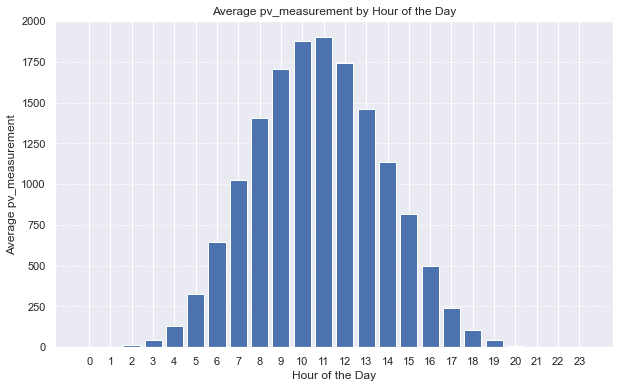

In [9]:
# Load your DataFrame (replace 'your_dataframe.csv' with your actual data file)
df = train_a.copy()

# Assuming you have a 'timestamp' column containing datetime information
# Convert it to a datetime object (if it's not already)
df['time'] = pd.to_datetime(df['time'])

# Extract the time component (hour) from the timestamp
df['hour'] = df['time'].dt.hour

# Define the column for which you want to calculate the average
desired_column = 'pv_measurement'  

# Create an empty dictionary to store the average values for each hour
average_values = {}

# Iterate through each hour of the day (0 to 23) and calculate the average
for hour in range(24):
    filtered_df = df[df['hour'] == hour]
    average_value = filtered_df[desired_column].mean()
    average_values[hour] = average_value

# Create lists for hours and corresponding average values
hours = list(average_values.keys())
averages = list(average_values.values())

# Plot the average values by hour
plt.figure(figsize=(10, 6))
plt.bar(hours, averages)
plt.xlabel('Hour of the Day')
plt.ylabel('Average ' + desired_column)
plt.title(f'Average {desired_column} by Hour of the Day')
plt.xticks(hours)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


In [10]:
# Load your DataFrame (replace 'your_dataframe.csv' with your actual data file)
df = train_b.copy()

# Assuming you have a 'timestamp' column containing datetime information
# Convert it to a datetime object (if it's not already)
df['time'] = pd.to_datetime(df['time'])

# Extract the time component (hour) from the timestamp
df['day_of_year'] = df['time'].dt.dayofyear

# Define the column for which you want to calculate the average
desired_column = 'pv_measurement'  # Replace 'column_name' with the actual column name

# Create an empty dictionary to store the average values for each day of the year
average_values = {}

# Iterate through each day of the year (1 to 365) and calculate the average
for day in range(1, 366):
    filtered_df = df[df['day_of_year'] == day]
    average_value = filtered_df[desired_column].mean()
    average_values[day] = average_value

# Create lists for days of the year and corresponding average values
days_of_year = list(average_values.keys())
averages = list(average_values.values())

# Fit a local regression (LOWESS) curve
lowess = sm.nonparametric.lowess(averages, days_of_year, frac=0.2)

# Extract the smoothed values
smoothed_values = lowess[:, 1]

# Find the day of the year with the maximum smoothed value
max_smoothed_value = max(smoothed_values)
max_smoothed_day = days_of_year[np.argmax(smoothed_values)]

# Plot the original data and the smoothed curve
arrowsize = 100
plt.figure(figsize=(12, 6))
plt.plot(days_of_year, averages, marker='o', linestyle='-', label='Original Data', color='blue', alpha=0.7)
plt.plot(days_of_year, smoothed_values, linestyle='-', color='red', linewidth=2, label='Smoothed Curve')
plt.scatter(max_smoothed_day, max_smoothed_value, color='green', label=f'Max Smoothed Value ({max_smoothed_value:.2f})', zorder=5)
plt.annotate(f'Day {max_smoothed_day}', xy=(max_smoothed_day, max_smoothed_value), 
             xytext=(max_smoothed_day, max_smoothed_value + arrowsize),  # Adjust the y-coordinate for the annotation
             arrowprops=dict(arrowstyle='->', color='green'), fontsize=12, color='green')
plt.xlabel('Day of the Year')
plt.ylabel(f'Average {desired_column}')
plt.title(f'Daily Trends in {desired_column} with Smoothed Curve')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()

# Show the plot
plt.show()

NameError: name 'sm' is not defined

In [11]:
features = ['absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx',
       'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
       'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m',
       'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
       'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'is_day:idx',
       'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
       'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
       'wind_speed_w_1000hPa:ms']

C:\Users\erlen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\erlen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


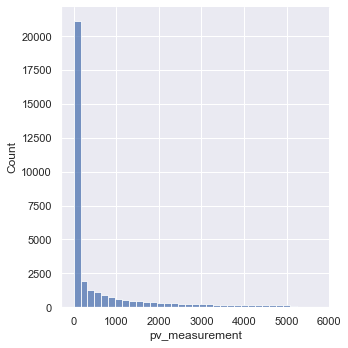

C:\Users\erlen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\erlen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


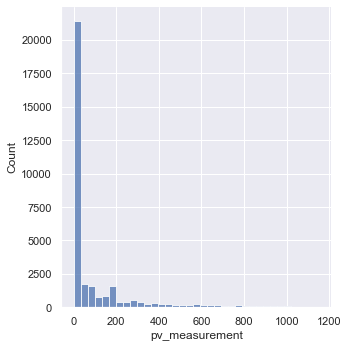

C:\Users\erlen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\erlen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


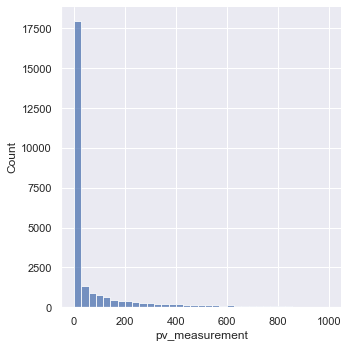

In [12]:
feature_name = "pv_measurement"
sns.displot(train_a[feature_name], bins = 35)
plt.show()

feature_name = "pv_measurement"
sns.displot(train_b[feature_name], bins = 35)
plt.show()

feature_name = "pv_measurement"
sns.displot(train_c[feature_name], bins = 35)
plt.show()

<AxesSubplot:title={'center':'Train/Test C'}, xlabel='time'>

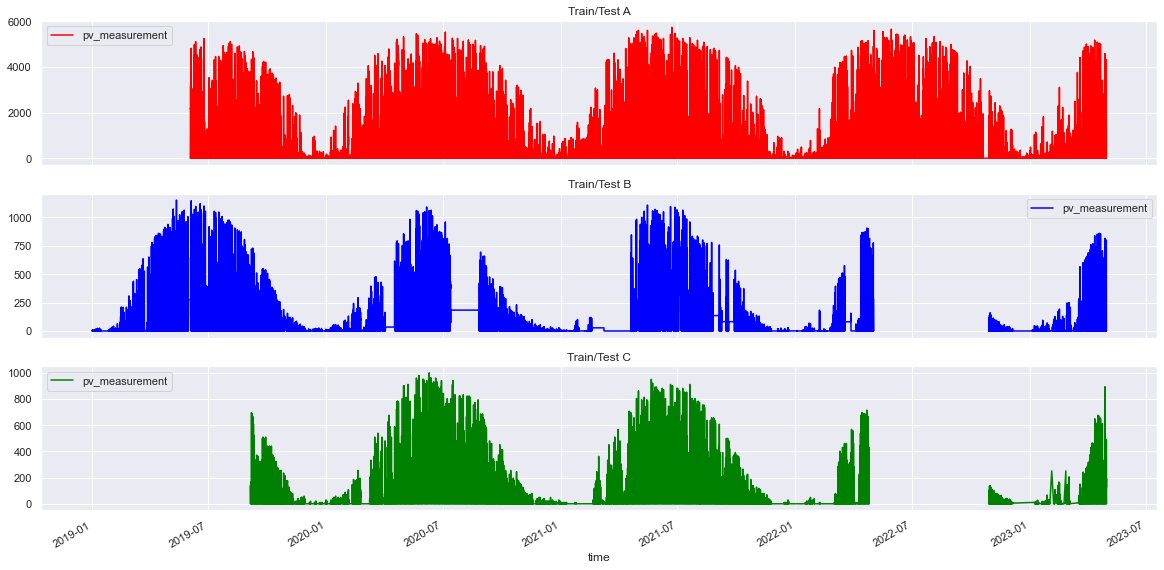

In [13]:
fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
feature_name = 'pv_measurement'
time = "time"
train_a[[time, feature_name]].set_index(time).plot(ax=axs[0], title='Train/Test A', color='red')
train_b[[time, feature_name]].set_index(time).plot(ax=axs[1], title='Train/Test B', color='blue')
train_c[[time, feature_name]].set_index(time).plot(ax=axs[2], title='Train/Test C', color='green')

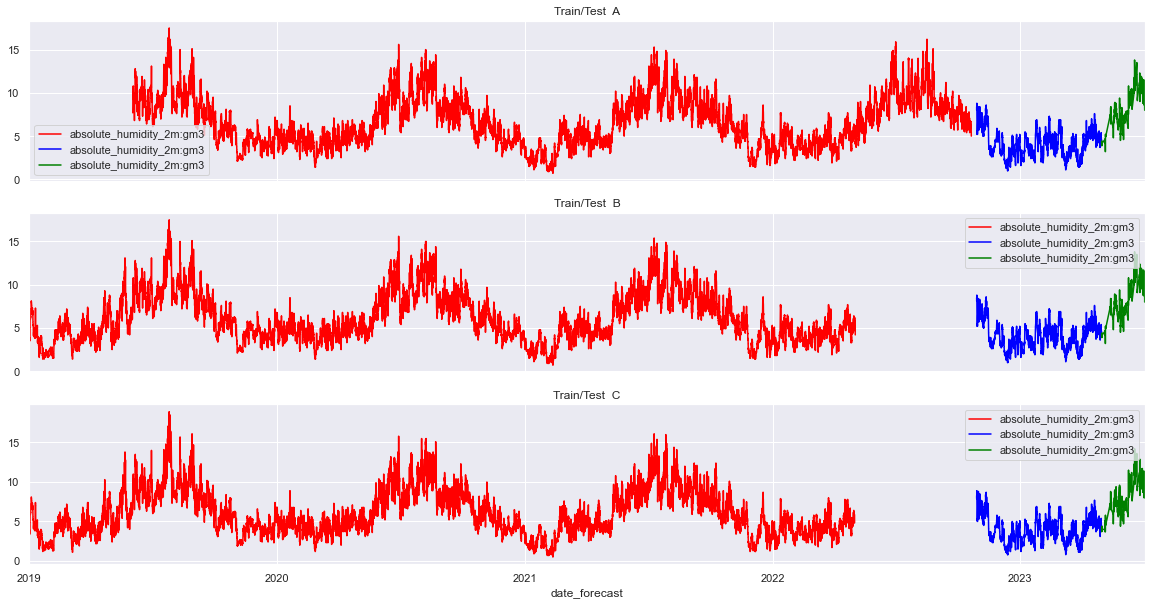

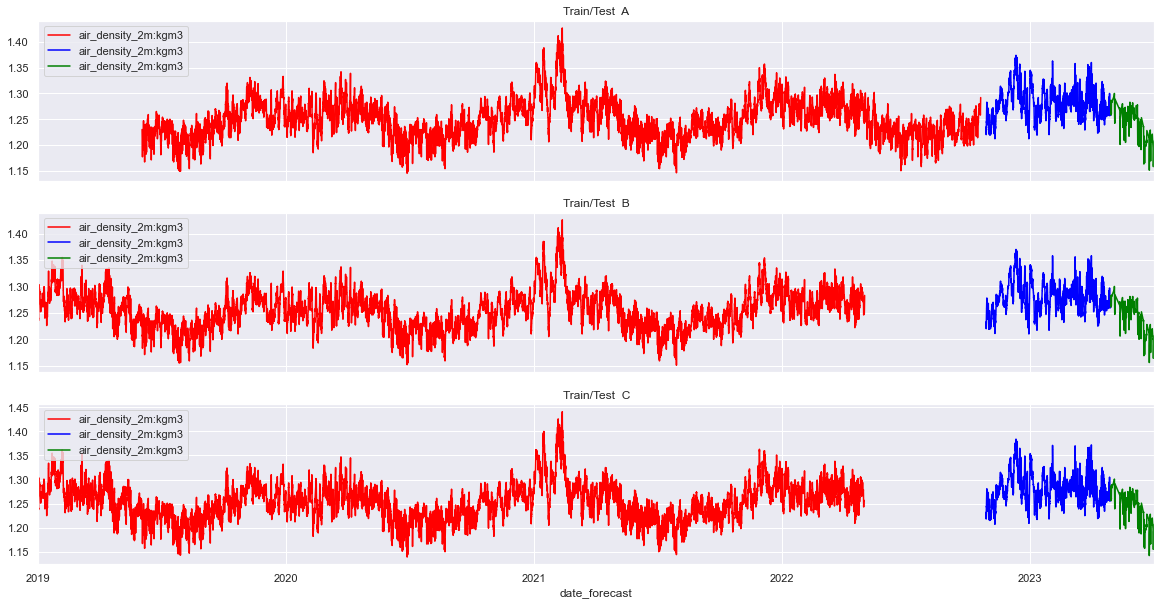

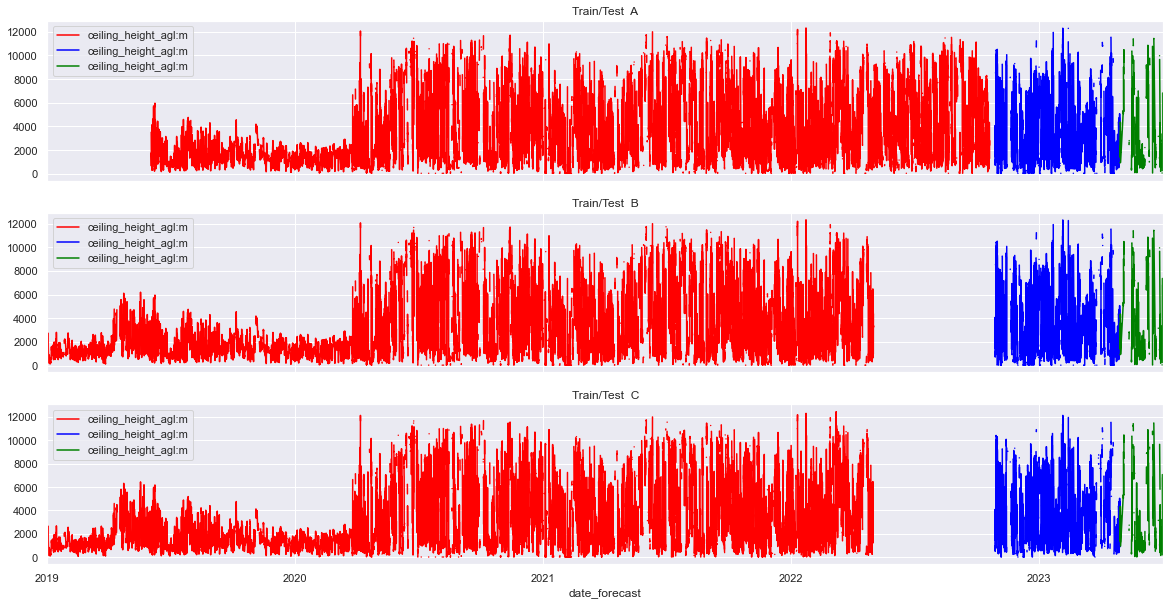

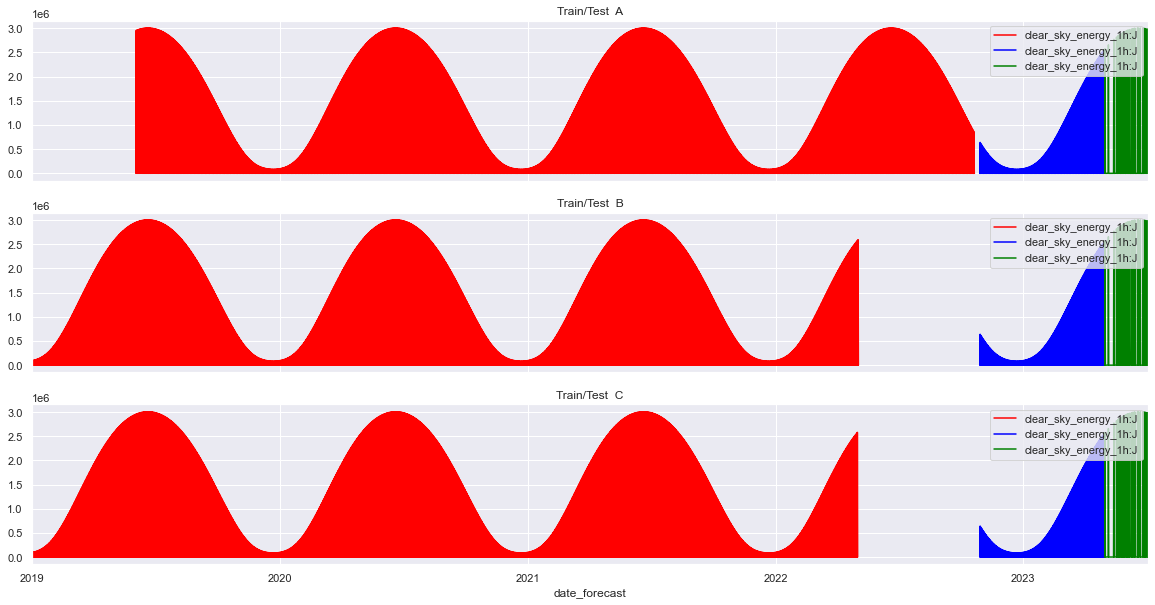

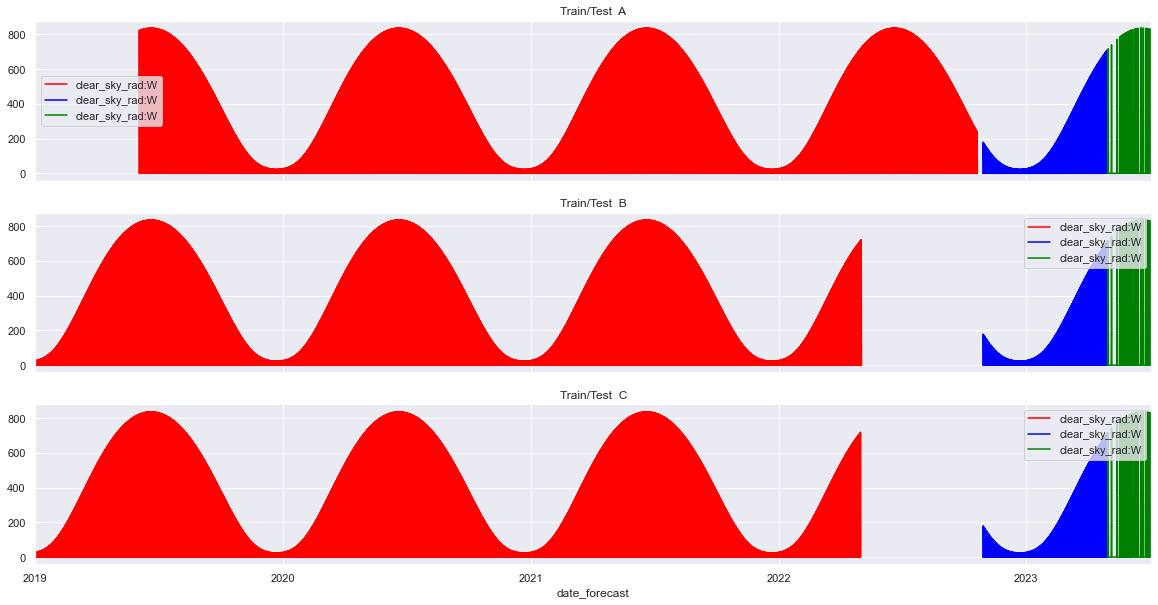

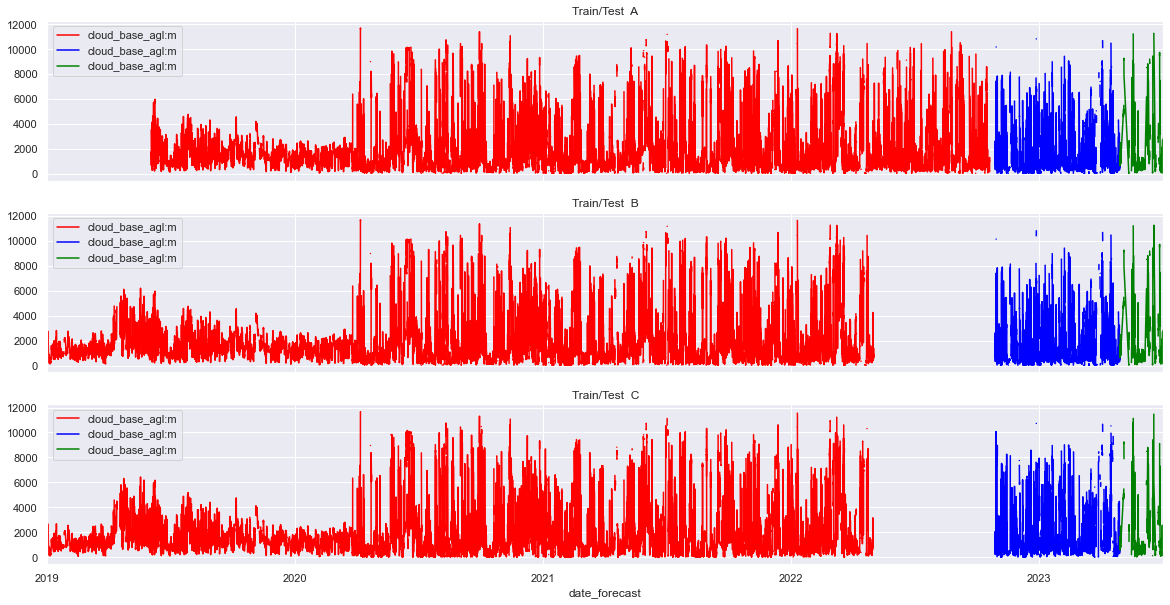

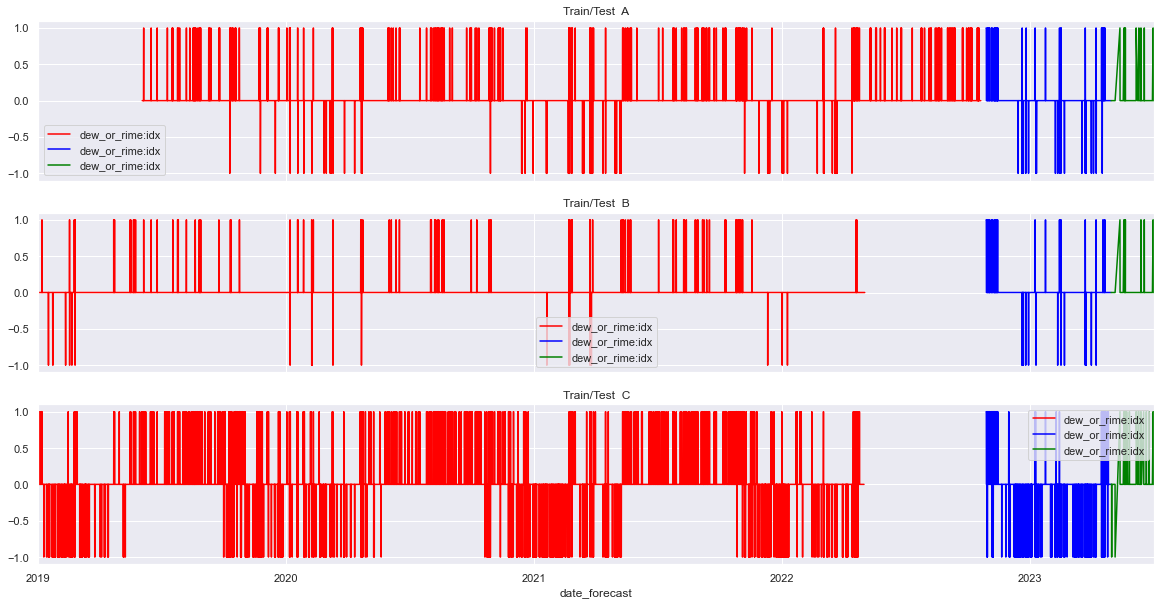

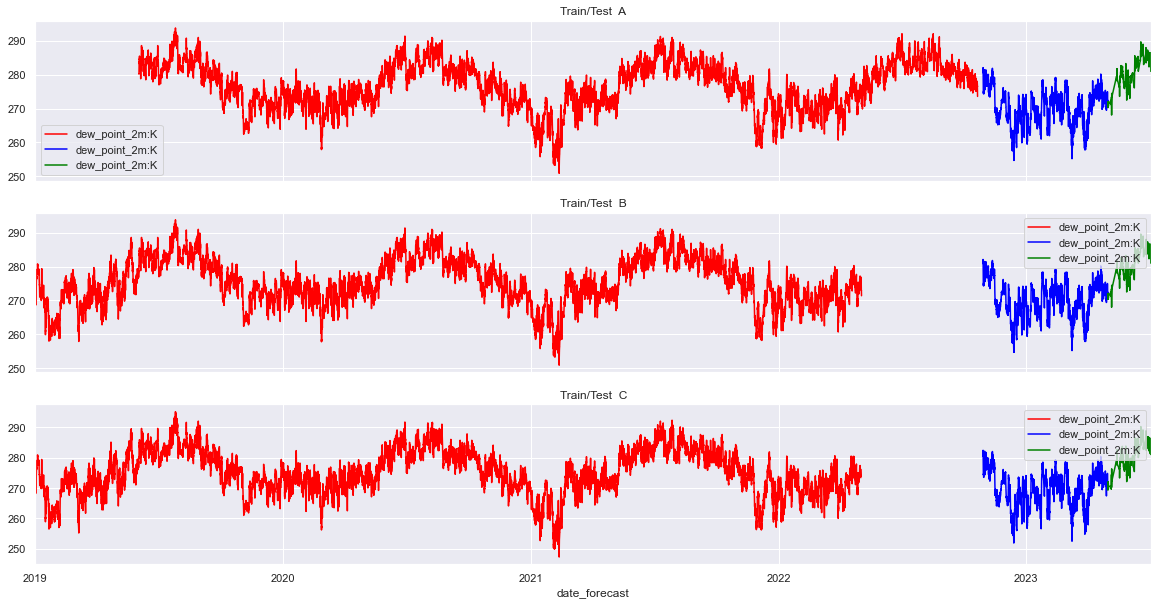

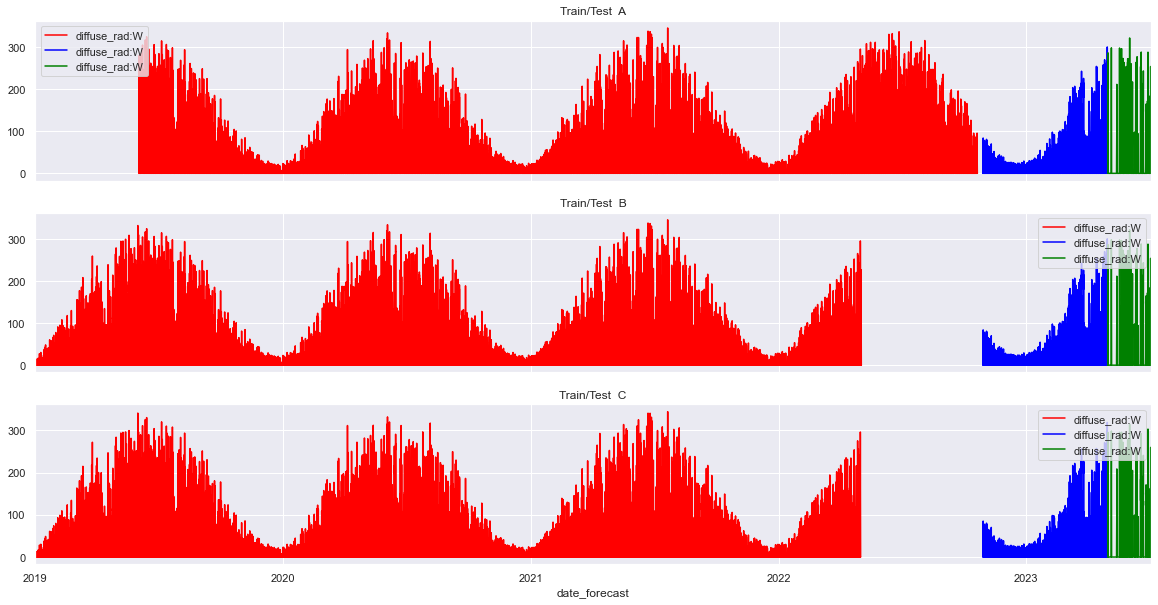

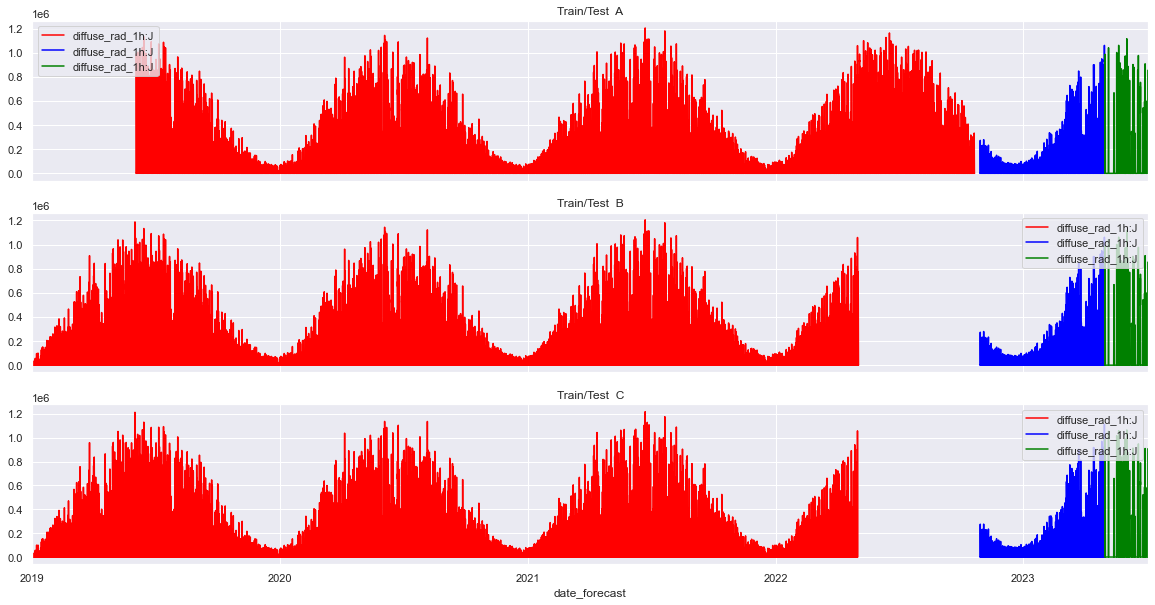

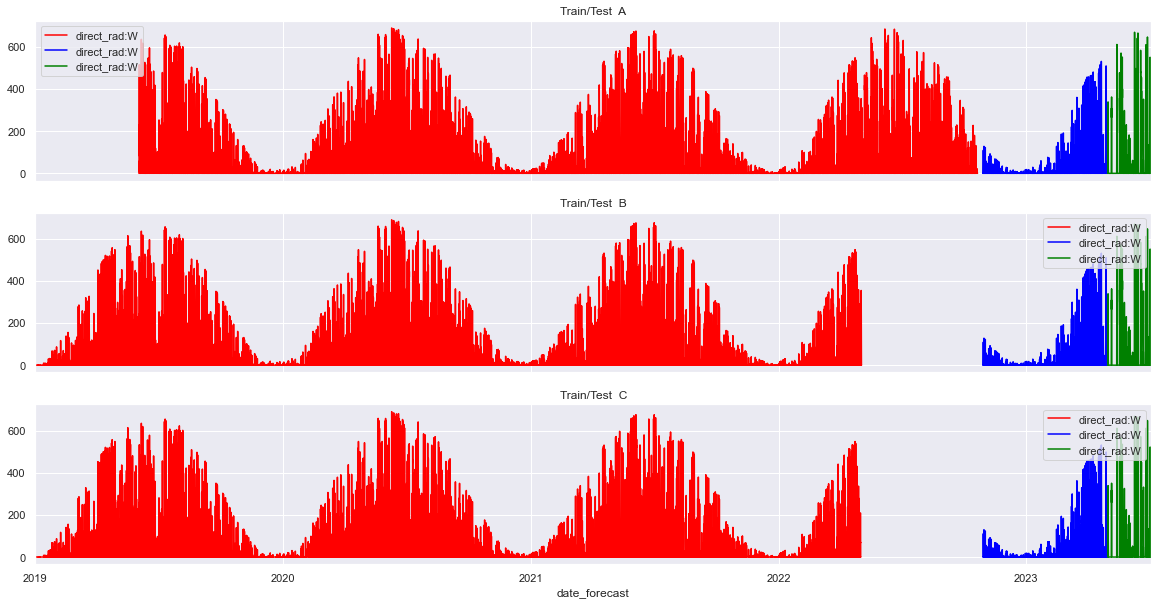

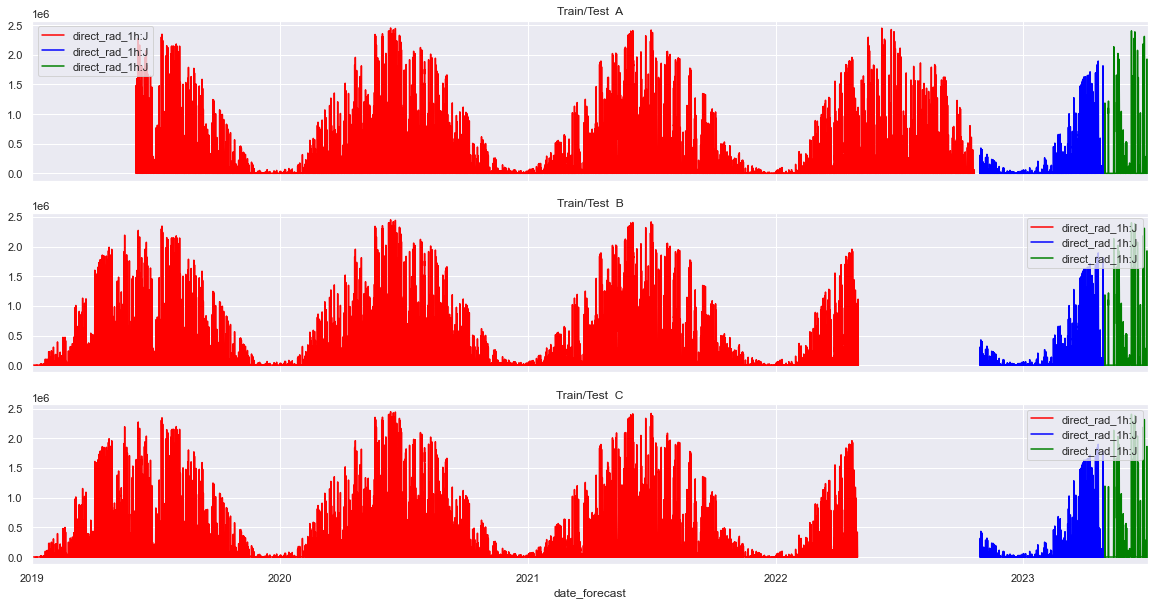

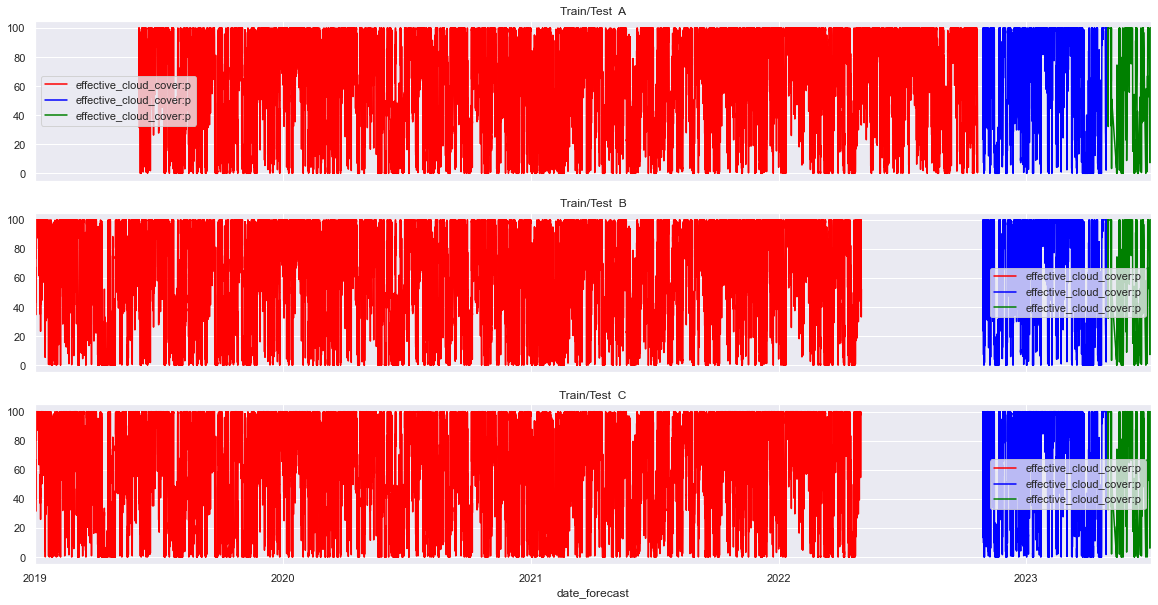

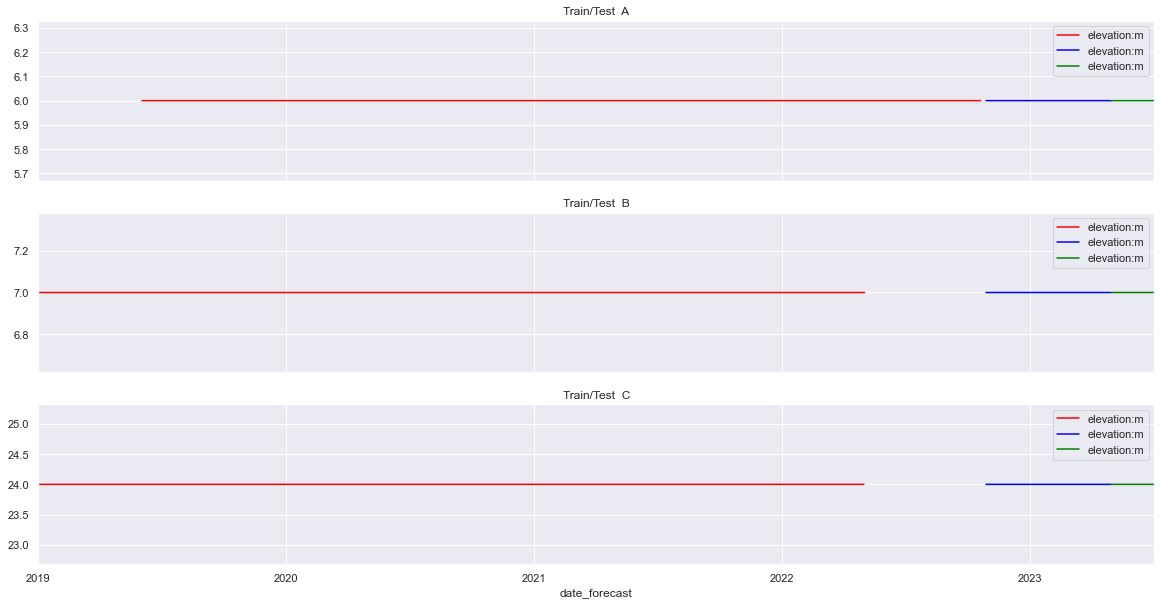

KeyboardInterrupt: 

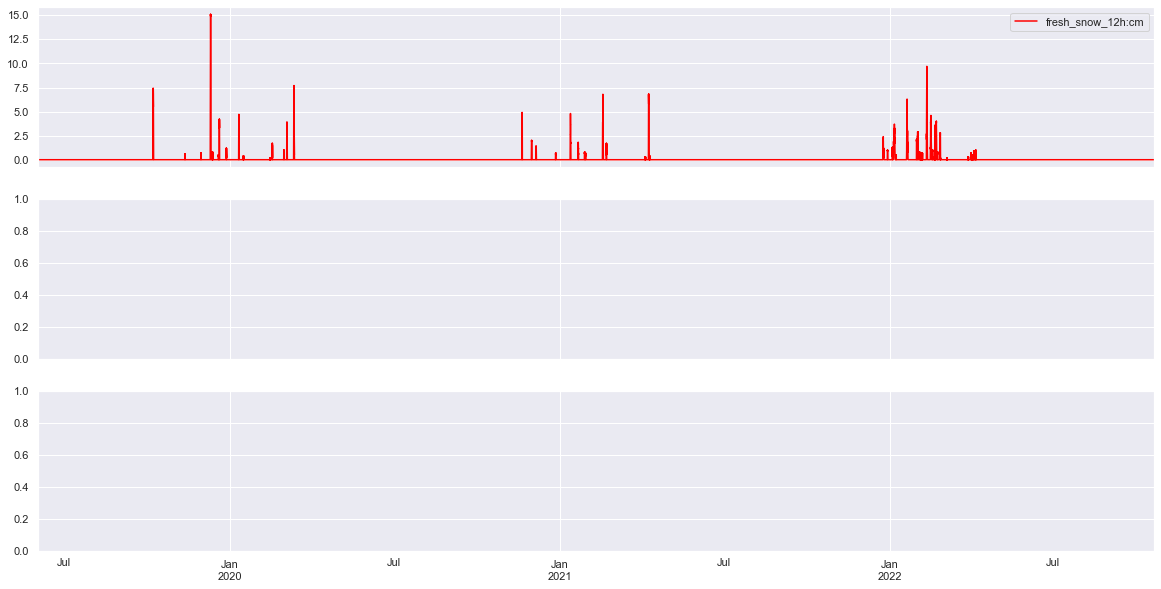

In [14]:
# Plotting a single feature
for feature_name in features:
    fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
    X_train_observed_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='red')
    X_train_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='blue')
    X_test_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test  A', color='green')

    X_train_observed_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='red')
    X_train_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='blue')
    X_test_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='green')

    X_train_observed_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='red')
    X_train_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='blue')
    X_test_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='green')
    plt.show()

# Merge Weather

In [15]:
def hour_mean(df_orig, time = "time"):
    # Copy df
    df = df_orig.copy()
    # rename time
    if time not in df.columns:
        df = df.rename(columns = {"date_forecast" : "time"})
    # Convert to datetime
    df[time] = pd.to_datetime(df[time])
    # Make datetime into index
    df.set_index(time, inplace = True)
    # Take mean within a hour
    df = df.resample("H").mean()
    # Convert time to column from index
    df = df.reset_index()
    return df
    

# Merge with observations

In [16]:
test = pd.read_csv("data/test.csv")

test_a = test[test.location == "A"].drop(columns = ["location"])
test_b = test[test.location == "B"].drop(columns = ["location"])
test_c = test[test.location == "C"].drop(columns = ["location"])

test_a["time"]= pd.to_datetime(test_a['time'])
test_b["time"] = pd.to_datetime(test_b['time'])
test_c["time"] = pd.to_datetime(test_c['time'])

In [17]:
X_a_mean = hour_mean(X_a)
X_b_mean = hour_mean(X_b)
X_c_mean = hour_mean(X_c)

train_a_full = pd.merge(train_a, X_a_mean, on = "time", how = "left").rename(columns = {"pv_measurement" : "target"})
train_b_full = pd.merge(train_b, X_b_mean, on = "time", how = "left").rename(columns = {"pv_measurement" : "target"})
train_c_full = pd.merge(train_b, X_c_mean, on = "time", how = "left").rename(columns = {"pv_measurement" : "target"})

test_a_full = pd.merge(test_a, X_c_mean, on = "time", how = "left").rename(columns = {"prediction" : "target"})
test_b_full = pd.merge(test_b, X_b_mean, on = "time", how = "left").rename(columns = {"prediction" : "target"})
test_c_full = pd.merge(test_c, X_c_mean, on = "time", how = "left").rename(columns = {"prediction" : "target"})

# Feature Engineering

In [19]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class HourlyMeanTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, timestamp_column_name='time', variable_column_name='variable'):
        self.timestamp_column_name = timestamp_column_name
        self.variable_column_name = variable_column_name
        self.hourly_means = None
    
    def fit(self, X, y=None):
        # Ensure the timestamp column is in datetime format
        X[self.timestamp_column_name] = pd.to_datetime(X[self.timestamp_column_name])
        
        # Extract the hour of the day from the timestamp
        X['hour_of_day'] = X[self.timestamp_column_name].dt.hour
        
        # Calculate the mean of the variable for each hour of the day
        self.hourly_means = X.groupby('hour_of_day')[self.variable_column_name].mean()
        
        # Drop the 'hour_of_day' column if present
        X.drop('hour_of_day', axis=1, inplace=True)
        
        return self
    
    def transform(self, X):
        # Ensure the timestamp column is in datetime format
        X[self.timestamp_column_name] = pd.to_datetime(X[self.timestamp_column_name])
        
        # Extract the hour of the day from the timestamp
        X['hour_of_day'] = X[self.timestamp_column_name].dt.hour
        
        # Map the hourly means to the DataFrame based on the hour of the day
        X['hourly_mean'] = X['hour_of_day'].map(self.hourly_means)
        
        # Drop the 'hour_of_day' column if present
        X.drop('hour_of_day', axis=1, inplace=True)
        
        return X




In [20]:
transformer = HourlyMeanTransformer("time", "target")

transformer.fit(train_a_full)
train_a_full = transformer.transform(train_a_full)
test_a_full = transformer.transform(test_a_full)

transformer.fit(train_b_full)
train_b_full = transformer.transform(train_b_full)
test_b_full = transformer.transform(test_b_full)

transformer.fit(train_c_full)
train_c_full = transformer.transform(train_c_full)
test_c_full = transformer.transform(test_c_full)




In [21]:
class DaylyMeanTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, timestamp_column_name='time', variable_column_name='variable', frac = 0.2):
        self.timestamp_column_name = timestamp_column_name
        self.variable_column_name = variable_column_name
        self.day_means = None
        self.lowess_means = None
        self.frac = frac
    
    def fit(self, X, y=None):
        # Ensure the timestamp column is in datetime format
        X[self.timestamp_column_name] = pd.to_datetime(X[self.timestamp_column_name])
        
        # Extract the hour of the day from the timestamp
        X['day_of_year'] = X[self.timestamp_column_name].dt.dayofyear
        
        # Calculate the mean of the variable for each hour of the day
        # self.day_means = X.groupby('day_of_year')[self.variable_column_name].mean()
        average_values = {}
        for day in range(1, 366):
            filtered_X = X[X['day_of_year'] == day]
            average_value = filtered_X[self.variable_column_name].mean()
            average_values[day] = average_value
        
        days_of_year = list( average_values.keys())
        averages = list( average_values.values())

        # Fit a local regression (LOWESS) curve
        lowess_reg = sm.nonparametric.lowess(averages, days_of_year, frac=self.frac)[:, 1]
        
        # Creat lowess dictionary
        self.lowess_means = {days_of_year[i]: lowess_reg[i] for i in range(len(days_of_year))}
        
        # Drop the 'hour_of_day' column if present
        X.drop('day_of_year', axis=1, inplace=True)
        
        return self
    
    def transform(self, X):
        # Ensure the timestamp column is in datetime format
        X[self.timestamp_column_name] = pd.to_datetime(X[self.timestamp_column_name])
        
        # Extract the hour of the day from the timestamp
        X['day_of_year'] = X[self.timestamp_column_name].dt.dayofyear
        
        # Map the hourly means to the DataFrame based on the hour of the day
        X['dayly_mean'] = X["day_of_year"].map(self.lowess_means)
        
        # Drop the 'hour_of_day' column if present
        X.drop('day_of_year', axis=1, inplace=True)
        
        return X




In [26]:
transformer = DaylyMeanTransformer("time", "target")

transformer.fit(train_a_full)
train_a_full = transformer.transform(train_a_full)
test_a_full = transformer.transform(test_a_full)

transformer.fit(train_b_full)
train_b_full = transformer.transform(train_b_full)
test_b_full = transformer.transform(test_b_full)

transformer.fit(train_c_full)
train_c_full = transformer.transform(train_c_full)
test_c_full = transformer.transform(test_c_full)

In [27]:
def calculate_time_difference(df, timestamp_column_name, reference_time_string):
    # Ensure the timestamp column is in datetime format
    df[timestamp_column_name] = pd.to_datetime(df[timestamp_column_name])
    
    # Define the reference time
    reference_time = pd.to_datetime(reference_time_string).time()
    
    # Calculate the time difference in minutes from 11 PM for each timestamp
    reference_column = df[timestamp_column_name].apply(
        lambda x: abs((x.time().hour - reference_time.hour) + (x.time().hour - reference_time.hour))
    )
    
    return reference_column


In [28]:
train_a_full["hour_from_11pm"] = calculate_time_difference(train_a_full, "time", "11:00:00")
train_b_full["hour_from_11pm"] = calculate_time_difference(train_b_full, "time", "11:00:00")
train_b_full["hour_from_11pm"] = calculate_time_difference(train_c_full, "time", "11:00:00")

test_a_full["hour_from_11pm"] = calculate_time_difference(test_a_full, "time", "11:00:00")
test_b_full["hour_from_11pm"] = calculate_time_difference(test_b_full, "time", "11:00:00")
test_b_full["hour_from_11pm"] = calculate_time_difference(test_c_full, "time", "11:00:00")

In [29]:
def calculate_day_difference_from_reference_day(df, timestamp_column_name, reference_day_of_year):
    # Ensure the timestamp column is in datetime format
    df[timestamp_column_name] = pd.to_datetime(df[timestamp_column_name])
    
    # Calculate the time difference in days from the reference day of the year
    reference_column = df[timestamp_column_name].apply(
        lambda x: abs( (x - pd.Timestamp(x.year, 1, 1)).days - (reference_day_of_year - 1))
    )
    
    return reference_column


In [30]:
train_a_full["day_from_160"] = calculate_day_difference_from_reference_day(train_a_full, "time", 160)
train_b_full["day_from_160"] = calculate_day_difference_from_reference_day(train_b_full, "time", 160)
train_c_full["day_from_160"] = calculate_day_difference_from_reference_day(train_c_full, "time", 160)

test_a_full["day_from_160"] = calculate_day_difference_from_reference_day(test_a_full, "time", 160)
test_b_full["day_from_160"] = calculate_day_difference_from_reference_day(test_b_full, "time", 160)
test_c_full["day_from_160"] = calculate_day_difference_from_reference_day(test_c_full, "time", 160)

In [31]:
def create_time_features(df, time = "time"):
    df['year'] = df[time].dt.year
    df['day'] = df[time].dt.day
    df['hour'] = df[time].dt.hour
    
    var_list = ["year", "day", "hour"]
    df = encode_cyclic(df, var_list)
    return df

def encode_cyclic(df, var_list):
    for var in var_list:
        df[f"{var}_sin"] = np.sin(2*np.pi*df[var]/df[var].max())
        df[f"{var}_cos"] = np.cos(2*np.pi*df[var]/df[var].max())
        del df[var]
    return df

In [32]:
def feature_decomposition(df_orig, decompose_cols, periodicity = "dayly"):
    df = df_orig.copy()
    df = df.dropna(subset = decompose_cols)
    if periodicity == "dayly" or periodicity =="all":
        for col in decompose_cols:
            decomp = seasonal_decompose(df[col], model='additive', period=24, extrapolate_trend='freq')
            df[f"{col}_trend_dayly"] = decomp.trend
            df[f"{col}_seasonal_dayly"] = decomp.seasonal
    if periodicity == "yearly" or periodicity == "all":
        for col in decompose_cols:
            decomp = seasonal_decompose(df[col], model='additive', period=24*365, extrapolate_trend='freq')
            df[f"{col}_trend_yearly"] = decomp.trend
            df[f"{col}_seasonal_yearly"] = decomp.seasonal
    return df

In [33]:
def plot_seasonal_decomposition_results(decomposed_df, cols_to_plot, periodicity):
    for col in cols_to_plot:
        fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
        plt.suptitle(f"Seasonal Decomposition - {col} ({periodicity} periodicity)")

        axs[0].set_title("Original")
        axs[0].plot(decomposed_df.index, decomposed_df[col])

        axs[1].set_title("Trend")
        axs[1].plot(decomposed_df.index, decomposed_df[f"{col}_trend_{periodicity.lower()}"])

        axs[2].set_title("Seasonal")
        axs[2].plot(decomposed_df.index, decomposed_df[f"{col}_seasonal_{periodicity.lower()}"])

        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

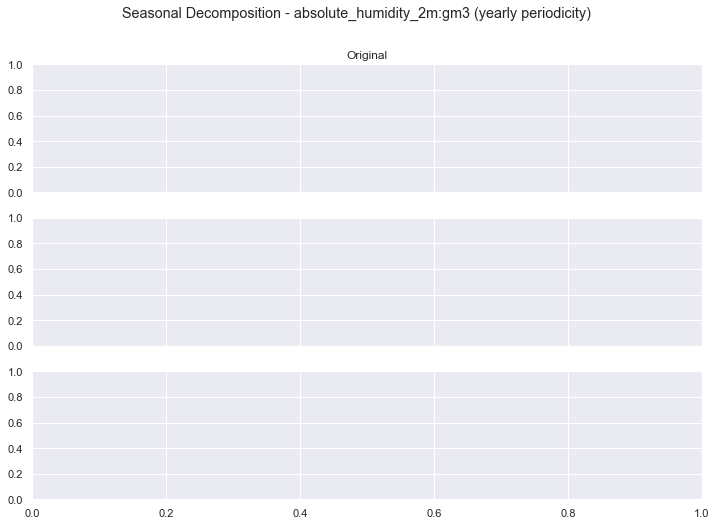

In [34]:
seasonal_features = [
    "absolute_humidity_2m:gm3",
    "air_density_2m:kgm3",
    "dew_point_2m:K",
    "diffuse_rad:W",
    "diffuse_rad_1h:J",
    "direct_rad:W",
    "direct_rad_1h:J",
    "msl_pressure:hPa",
    "pressure_100m:hPa",
    "pressure_50m:hPa",
    "relative_humidity_1000hPa:p",
    "sfc_pressure:hPa",
    "sun_azimuth:d",
    "t_1000hPa:K",
    "wind_speed_10m:ms",
    "visibility:m",
    "wind_speed_u_10m:ms",
    "wind_speed_v_10m:ms"
]


train_a_seasonal = feature_decomposition(train_a_full, seasonal_features, "yearly")
plot_seasonal_decomposition_results(train_a_seasonal, seasonal_features, "yearly")

In [35]:
def create_features(df_orig, decompose_cols, periodicity = "dayly"):
    # copy
    df = df_orig.copy()
    # Create time features
    df = create_time_features(df)
    #Decompose features
    # df = feature_decomposition(df, decompose_cols, periodicity)
    return df

seasonal_features = [
    "absolute_humidity_2m:gm3",
    "air_density_2m:kgm3",
    "dew_point_2m:K",
    "diffuse_rad:W",
    "diffuse_rad_1h:J",
    "direct_rad:W",
    "direct_rad_1h:J",
    "msl_pressure:hPa",
    "pressure_100m:hPa",
    "pressure_50m:hPa",
    "relative_humidity_1000hPa:p",
    "sfc_pressure:hPa",
    "sun_azimuth:d",
    "t_1000hPa:K",
    "wind_speed_10m:ms",
    "visibility:m",
    "wind_speed_u_10m:ms",
    "wind_speed_v_10m:ms"
]

train_a_pre = create_features(train_a_full, seasonal_features)
train_b_pre = create_features(train_b_full, seasonal_features)
train_c_pre = create_features(train_c_full, seasonal_features)

test_a_pre = create_features(test_a_full, seasonal_features)
test_b_pre = create_features(test_b_full, seasonal_features)
test_c_pre = create_features(test_c_full, seasonal_features)

# Modeling

## XGBoost

In [36]:
train_a_pure = train_a_pre[~np.isnan(train_a_pre["target"])] # tar ut nan verdien i pv_measurement
train_b_pure = train_b_pre[~np.isnan(train_b_pre["target"])]
train_c_pure = train_c_pre[~np.isnan(train_c_pre["target"])]

X_train_a = train_a_pure.drop(columns = ["time", "target", "date_calc"]) # dropp unyttig info
X_train_b = train_b_pure.drop(columns = ["time", "target", "date_calc"])
X_train_c = train_c_pure.drop(columns = ["time", "target", "date_calc"])

X_test_a = test_a_pre.drop(columns = ["time", "target", "date_calc", "id"]) # ta bort target, som er y
X_test_b = test_b_pre.drop(columns = ["time", "target", "date_calc", "id"])
X_test_c = test_c_pre.drop(columns = ["time", "target", "date_calc", "id"])

y_train_a = train_a_pure.target
y_train_b = train_b_pure.target
y_train_c = train_c_pure.target

In [37]:
X_train_a["location"] = "A"
X_train_b["location"] = "B"
X_train_c["location"] = "C"

X_test_a["location"] = "A"
X_test_b["location"] = "B"
X_test_c["location"] = "C"

X_train = pd.concat([X_train_a, X_train_b, X_train_c])
X_test = pd.concat([X_test_a, X_test_b, X_test_c])

X_train = pd.get_dummies(X_train, columns=['location'], dtype = int)
X_test = pd.get_dummies(X_test, columns=['location'], dtype = int)

In [38]:
original_shape_a = y_train_a.shape
original_shape_b = y_train_b.shape
original_shape_c = y_train_c.shape

scaler_a = StandardScaler()
scaler_b = StandardScaler()
scaler_c = StandardScaler()

y_train_scaled_a = scaler_a.fit_transform(np.array(y_train_a).reshape(-1, 1)).reshape(original_shape_a)
y_train_scaled_b = scaler_b.fit_transform(np.array(y_train_b).reshape(-1, 1)).reshape(original_shape_b)
y_train_scaled_c = scaler_c.fit_transform(np.array(y_train_c).reshape(-1, 1)).reshape(original_shape_c)

y_train = np.hstack([y_train_scaled_a , y_train_scaled_b, y_train_scaled_c])

## Correlation

C:\Users\erlen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\erlen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


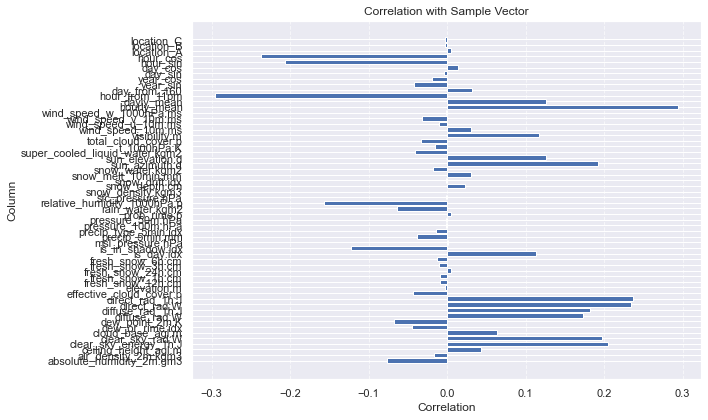

                            Column  Correlation
0         absolute_humidity_2m:gm3      -0.0760
1              air_density_2m:kgm3      -0.0170
2             ceiling_height_agl:m       0.0431
3            clear_sky_energy_1h:J       0.2052
4                  clear_sky_rad:W       0.1977
5                 cloud_base_agl:m       0.0632
6                  dew_or_rime:idx      -0.0444
7                   dew_point_2m:K      -0.0676
8                    diffuse_rad:W       0.1727
9                 diffuse_rad_1h:J       0.1824
10                    direct_rad:W       0.2343
11                 direct_rad_1h:J       0.2371
12         effective_cloud_cover:p      -0.0433
13                     elevation:m      -0.0026
14               fresh_snow_12h:cm      -0.0087
15                fresh_snow_1h:cm      -0.0087
16               fresh_snow_24h:cm       0.0053
17                fresh_snow_3h:cm      -0.0102
18                fresh_snow_6h:cm      -0.0124
19                      is_day:idx      

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def correlation_with_vector(df, vector, vector_name="Vector"):
    """
    Calculate the correlation between every column in a DataFrame and a vector.
    
    Parameters:
    - df: DataFrame
        The input DataFrame with columns to calculate correlations.
    - vector: list or numpy array
        The vector with which to calculate correlations.
    - vector_name: str
        Name of the vector for visualization purposes (default is "Vector").
    
    Returns:
    - correlations: DataFrame
        A DataFrame containing the correlations between columns and the vector.
    """
    # Calculate correlations
    correlations = X_train.corrwith(pd.Series(y_train))

    # Create a list of correlations
    correlation_list = correlations.reset_index()
    correlation_list.columns = ["Column", "Correlation"]

    # Create a visualization
    plt.figure(figsize=(10, 6))
    plt.barh(correlation_list["Column"], correlation_list["Correlation"])
    plt.xlabel("Correlation")
    plt.ylabel("Column")
    plt.title(f"Correlation with {vector_name}")
    plt.grid(axis="x", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    return correlation_list

# Example usage:
if __name__ == "__main__":
    # Create a sample DataFrame
    data = {
        "A": np.random.rand(100),
        "B": np.random.rand(100),
        "C": np.random.rand(100),
    }
    df = pd.DataFrame(data)

    # Create a sample vector
    vector = np.random.rand(100)

    # Calculate correlations and display the results
    correlation_result = correlation_with_vector(df, vector, vector_name="Sample Vector")
    print(correlation_result)


In [40]:
import pandas as pd
import numpy as np

def columns_below_correlation_threshold(X, y, threshold=0.1):
    """
    Return a list of columns with correlations below the specified threshold.

    Parameters:
    - df: DataFrame
        The input DataFrame with columns to check for correlations.
    - threshold: float
        The correlation threshold below which columns will be included in the list (default is 0.1).

    Returns:
    - below_threshold_columns: list
        A list of column names with correlations below the threshold.
    """
    # Calculate correlations
    correlations = X.corrwith(pd.Series(y))

    # Extract column names with correlations below the threshold
    below_threshold_columns = []
    for col in correlations.keys():
        if abs(correlations[col]) < threshold:
            below_threshold_columns.append(col)

    return below_threshold_columns

below_threshold_columns = columns_below_correlation_threshold(X_train, y_train, threshold=0.01)


C:\Users\erlen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\erlen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [41]:
original_list = below_threshold_columns
elements_to_remove = ["location_A", "location_B", "location_C"]

below_threshold_columns = [x for x in original_list if x not in elements_to_remove]

In [42]:
below_threshold_columns

['elevation:m',
 'fresh_snow_12h:cm',
 'fresh_snow_1h:cm',
 'fresh_snow_24h:cm',
 'msl_pressure:hPa',
 'pressure_100m:hPa',
 'pressure_50m:hPa',
 'prob_rime:p',
 'sfc_pressure:hPa',
 'snow_drift:idx',
 'wind_speed_w_1000hPa:ms',
 'day_sin']

In [44]:
X_train_sub = X_train.drop(columns = below_threshold_columns)
X_test_sub = X_test.drop(columns = below_threshold_columns)

In [45]:
# Create an XGBoost Regressor
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror',  # Specify regression as the objective
                                 n_estimators=100,  # Number of boosting rounds (trees)
                                 learning_rate=0.1,  # Step size for updates
                                 max_depth=3)  # Maximum depth of each tree

# Fit the regressor to the training data
xgb_regressor.fit(X_train_sub, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [46]:
X_test_sub_a = X_test_sub[X_test_sub["location_A"] == 1]
X_test_sub_b = X_test_sub[X_test_sub["location_B"] == 1]
X_test_sub_c = X_test_sub[X_test_sub["location_C"] == 1]

y_pred_a = xgb_regressor.predict(X_test_sub_a).reshape(-1,1)
y_pred_b = xgb_regressor.predict(X_test_sub_b).reshape(-1,1)
y_pred_c = xgb_regressor.predict(X_test_sub_c).reshape(-1,1)

test_a_pre["target"] = scaler_a.inverse_transform(y_pred_a)
test_b_pre["target"] = scaler_b.inverse_transform(y_pred_b)
test_c_pre["target"] = scaler_c.inverse_transform(y_pred_c)

test_pre = pd.concat([test_a_pre, test_b_pre, test_c_pre])

In [47]:
test_pre = pd.concat([test_a_pre, test_b_pre, test_c_pre])

test_pre["target"] = xgb_regressor.predict(X_test_sub)

In [48]:
test_pre['target'] = test_pre['target'].apply(lambda x: max(0, x))

In [49]:
submission = test_pre[["id", "target"]]
submission.columns = ["id", "prediction"]

submission.to_csv("submission_xgb_complete_9.csv", index = False)

In [ ]:
import h2o 
from h2o.automl import H2OAutoML 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, OrdinalEncoder

h2o.init()


h2o_frame = h2o.H2OFrame(X_train_sub)

x_train = h2o_frame.columns

model = H2OAutoML(sort_metric='RMSLE', max_models=10, exclude_algos=["DeepLearning"], seed=666)

model.train(x=x_train, y=y_train, training_frame=h2o_frame)

X_test = h2o.H2OFrame(X_test_sub)

y_pred = model.predict(X_test)



y_pred = h2o.as_list(y_pred)


orig_test_data = pd.read_csv('data/stores_test.csv')



y_pred = 10 ** y_pred


print(y_pred[y_pred<0].shape)
y_pred[y_pred<0] = 0


submission = pd.DataFrame()
submission['id'] = orig_test_data.store_id
submission['predicted'] = y_pred

filepath_test = Path('sample_submission.csv')

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv(filepath_test, index=False)
submission

### Individual model

In [ ]:
xgb_model_a = xgb.XGBRegressor(n_estimators=1000, objective = "reg:tweedie")
xgb_model_a.fit(X_train_a, y_train_a,
       verbose=False)

xgb_model_b = xgb.XGBRegressor(n_estimators=1000, objective = "reg:tweedie")
xgb_model_b.fit(X_train_b, y_train_b,
       verbose=False)

xgb_model_c = xgb.XGBRegressor(n_estimators=1000, objective = "reg:tweedie")
xgb_model_c.fit(X_train_c, y_train_c,
       verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:tweedie', predictor=None, ...)

In [ ]:
test_a_pre["target"] = xgb_model_a.predict(X_test_a)
test_b_pre["target"] = xgb_model_b.predict(X_test_b)
test_c_pre["target"] = xgb_model_c.predict(X_test_c)

NameError: name 'xgb_model_a' is not defined

<Axes: title={'center': 'Train/Test A'}, xlabel='time'>

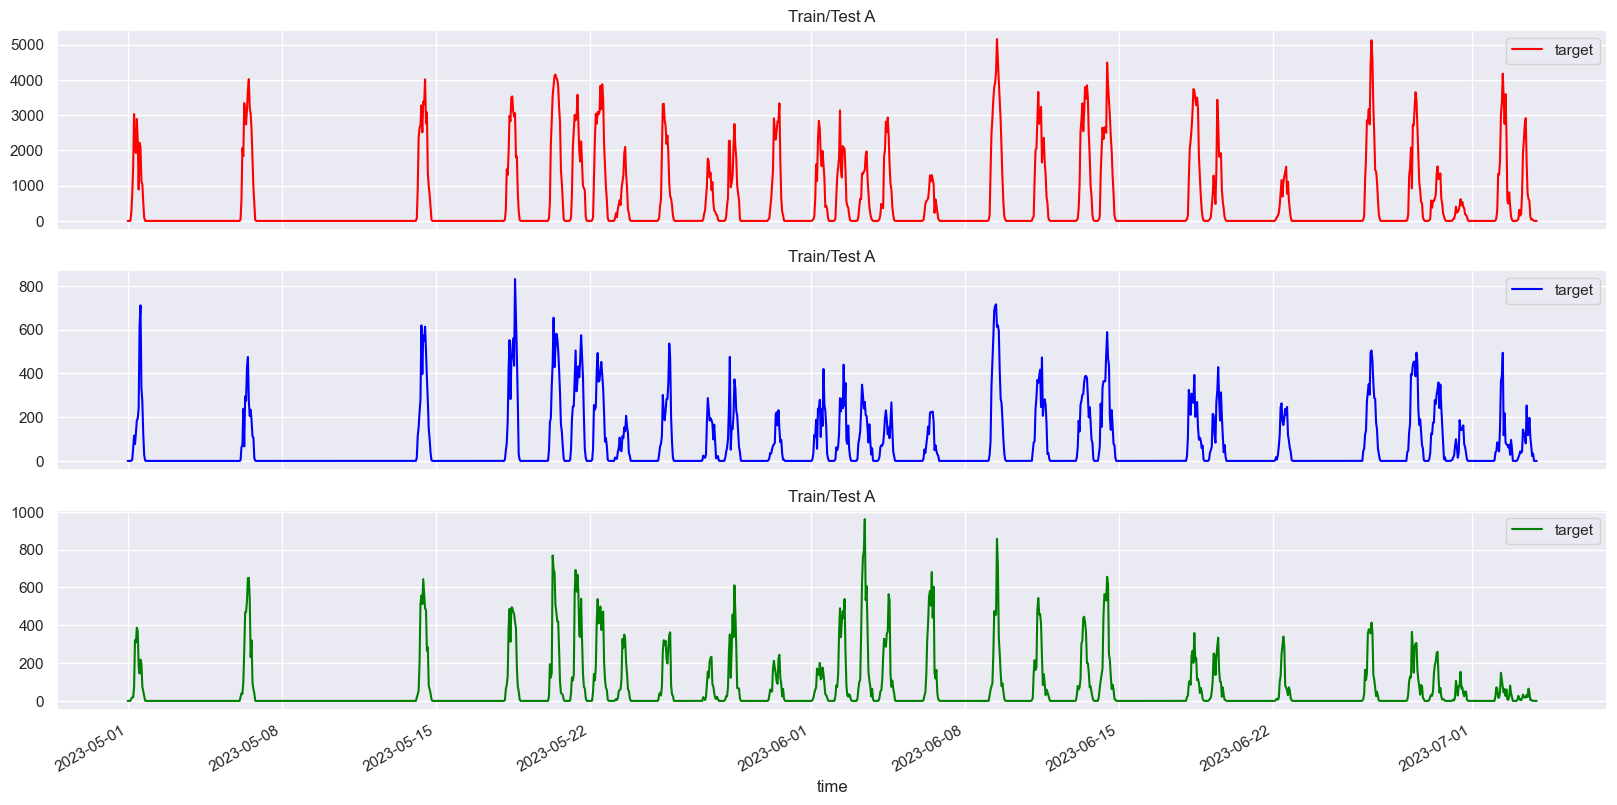

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
feature_name = "target"
time = "time"
test_a_pre[[time, feature_name]].set_index(time).plot(ax=axs[0], title='Train/Test A', color='red')
test_b_pre[[time, feature_name]].set_index(time).plot(ax=axs[1], title='Train/Test A', color='blue')
test_c_pre[[time, feature_name]].set_index(time).plot(ax=axs[2], title='Train/Test A', color='green')

In [ ]:
submission_a = test_a_pre[["id","target"]]
submission_a.columns = ["id", "prediction"]

submission_b = test_b_pre[["id","target"]]
submission_b.columns = ["id", "prediction"]

submission_c = test_c_pre[["id","target"]]
submission_c.columns = ["id", "prediction"]

submission = pd.concat([submission_a, submission_b, submission_c])

In [ ]:
submission.to_csv("submission_xgb_complete_3.csv", index = False)

## Plot importance

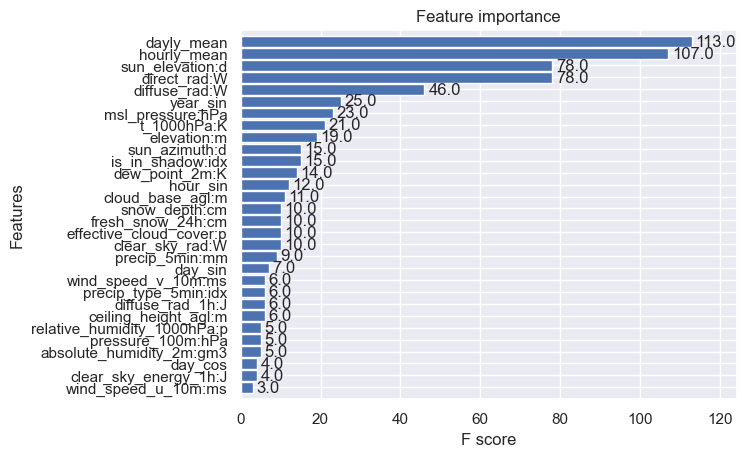

In [ ]:
_ = plot_importance(xgb_regressor, height=0.9, max_num_features=30)

## LightGBM